# Mixer - Setup

Author: Felix Hoffmann <br>
Date: 04/25/2024 <br>
Based on: Reduced Basis Methods for Partial Differential Equations - An Introduction

This Tutorial will show how to setup the Mixer Simulation of [Reduced Basis Methods for Partial Differential Equations - An Introduction](...), Chapter 3.8 - An Illustrative Numerical Example. We will setup the problem, define the weak formulation, and solve the problem. In further Tutorials we will have a deeper dive into this problem. 

---

### The Problem
We study a steady heat conduction-convection problem, which models the temperature of a fluid flowing into a heat exchanger device (mixer).

We can model the problem as followed: $$
    \left\{
    \begin{matrix}
        -\nu \Delta u + \vec{b}\cdot\nabla u = 0 & \mathrm{in} ~ \Omega\\
        u = g_p & \mathrm{on} ~ \Gamma_p & \mathrm{for} ~ p=1,2,3\\
        u = 0 & \mathrm{on} ~ \Gamma_w \cup \Gamma_{in}\\
        \nu \nabla u \cdot \vec{n} = 0 & \mathrm{on} ~ \Gamma_n
    \end{matrix}
    \right.
$$
with temperature $u$, domain $\Omega \in \mathrm{R}^2$, thermal diffusivity $\nu$, convection field $\vec{b}$. Technically speaking we need to calculate the convection field by solving the Navier-Stokes Equation. For convenience reasons, we just define our own convection field. 

The fluid enters the channel with a reference temperature $u=0$, then the heating process is regulated by the temperature valves $g_p$ imposed on the baffles $\Gamma_p$. Therefore we have $P=4$ physical parameters, $\mu_p = g_p$ for $p=1,2,3$ and the Péclet number $\mu_4 = 1/\nu$. We choose the parameter domain $\mathcal{P} = [0,12]^3 \times [1, 600] \in \mathrm{R}^4$.

---
Physical Interpretation: <br> 
This is a heat exchanger, also called mixer. On the outer boundary $\Gamma_w$, we have a reference Temperature of $u=0$. Also, the fluid is entering with a reference temperature of $u=0$. On the baffles we are heating up the air to a temperature $u=g_p$, respectively at $\Gamma_p$. The outlet $\Gamma_n$ is blocked so that there doesn't take place a change in temperature.<br>
The flow field $\vec{b}$ models the air flow through the mixer. The physical parameters are the heating temperatures at the baffles and the coupling of diffusion ($\nu \Delta u$) and heat transportation ($\vec{b} \cdot \nabla u$) (see reaction-diffusion process).

---

### Construct the Geometry
First at all we need to construct the Geometry, or more precisely the mesh. Simple meshes can be constructed directly with ```dolfinx```. For more complicated meshes you should use [Gmsh](https://gmsh.info/). We will use Gmeh here for illustration purposes. A simple mesh like this can also be easily constructed directly in ```dolfinx```. 

0. Install ```Gmsh``` over [Gmsh - Download](https://gmsh.info/#Download).
1. Start the Graphical User Interface (Experienced users can also use the command line).
2. ```Choose Modules -> Geometry -> Elementary Entities -> Add -> Point``` and place the desired points.
3. Then choose under the same tab ```Line``` to connect the points. Watch out to connect the points in order, because the direction matters!
4. Go to ```Plane Surface``` under the same tab and click the boundary. If it works you should see two dashed gray lines.
5. Go now to ```Choose Modules -> Geometry -> Physical Groups -> Add -> Surface``` and mark the surface as a physical group.
6. Go now to ```Modules -> Mesh -> 2D``` and create a first simple 2D mesh.
7. Refine the mesh with ```Refine Splitting``` until you achieve the desired finesse.
8. Then go to ```Smooth 2D``` the smooth the grid.
9. Export the file as a ```*.mesh``` file. This can be used in ```dolfinx```.

My personal recommendation is to write the geometry by hand and then do the refinement steps in the graphic GUI because the graphic GUI su*ks...

--- A short tutorial on writing ```*.gui``` by hand ---
1. Define Points by ```Point("Name") = {X, Y, Z, lc};``` with ```X, Y, Z``` coordinate and ```lc``` the desired mesh size around that point.
2. Define Lines by ```Line("Name") = {<<Point Name>>, <<Point Name>>};``` (type without ```<< >>```).
3. Define the connected boundary by ```Curve Loop("Name") = {<<Line Name>>, ..., <<Line Name>>};```. Watch out for the right order and direction of the individual lines.
4. Create a Surface by ```Plane Surface("Name") = {Curve Loop Name};```
5. Define the Physical Entities with ```Physical Curve("Name") = {<<Line Name>>, ..., <<Line Name>>};``` (with the lines the same as the ```Curve Loop```) and ```Physical Surface("Name") = {Plane Surface Name};```.
6. Go to the Gmsh GUI and refine the net. Export as ```*.msh```.

The last step can also be done via the command line. You can also define the points in that script dynamic and use variables. In my opinion, it's easiest to write a small Python script to automatize the creation of meshes. 

<font color='Red'> <b>ToDo:</b> </font> <br>
Create Meshes with 1, 2, 3, 4, and 5 valves. Also, refine the meshes around all corners. Write a Python script to dynamically influence the characteristic sizes and distances of the baffles.

---

### The Math behind
Let's construct the weak formulation. <br>
As always, multiply by a testfunction $v$, partial integration, and Greens Formula. We get $$
    a(u,v;\mu) = \dfrac{1}{\mu_4} \int_\Omega \nabla u \cdot \nabla v \,\mathrm{d}\Omega ~~ + ~~ \int_\Omega \vec{b}\cdot \nabla u \,v\,\mathrm{d}\Omega~,\qquad f(v;\mu) = - \sum\limits^{3}_{p=1} a(r_p(\mu),v;\mu)
$$

The book splits these formulas into the simple affine decomposition. Because we're using ```FEniCSx``` we don't need to do that (yet).

---

### Setup FEniCSx
Solving this problem with ```FEniCSx``` requires the following basic steps:
1. Read in the mesh.
2. Define Function Space, Trail-/Testfunctions and Vector Field.
3. Define the weak formulation. 
4. Define the Boundary conditions.
5. Solve the problem.

---

##### The Mesh
We can read in the ```*.msh``` File. To read it in we'll use ```dolfinx.io.gmshio```. We once again need to specifiy if we want to use global or local computation and also specify the net dimension. <br>
The function will return the actual Mesh object ```mesh```, ```cell_markers``` which represents the physical group for cells, and ```facet_tags```which represents the physical group for facets. <br>
You can use ```facet_tags``` if you have defined physical groups for facets, for example labeling the boundaries. We didn't do that here, so we can neglect this parameter

In [1]:
def readMesh(fileName):    
    import dolfinx.io as xio
    from mpi4py import MPI 
    
    mesh, cell_markers, facet_markers = xio.gmshio.read_from_msh(fileName, MPI.COMM_WORLD, gdim=2)
    return mesh, cell_markers, facet_markers

---

##### Space, Trail-/Testfunctions
We once again use the piecewise linear functions as a function space. See chapter 1.

In [2]:
def createFunctionSpace(mesh):
    V = xfem.FunctionSpace(mesh, ("Lagrange", 1))
    u = ufl.TrialFunction(V)
    v = ufl.TestFunction(V)
    
    return V, u, v

---

##### Vector Field
Technically we should solve the Navier-Stokes Equation to get the flow field $\vec{b}$. This is a nonlinear equation and therefore harder to solve, but by far not impossible! Nevertheless, we create here our vector field by hand. This is physically not correct, but close enough for our purposes. For low Reynolds numbers, the latter can be obtained as the solution of the stationary Navier-Stokes equations.  

<font color='Red'> <b>ToDo:</b> </font> <br>
Get the exact vector field by solving the (stationary) Navier-Stokes equation.

Because of quite tedious technical reasons, you can find the vector field in the reference folder. You run in several issues trying to define piecewise functions in ```FEniCSx```.

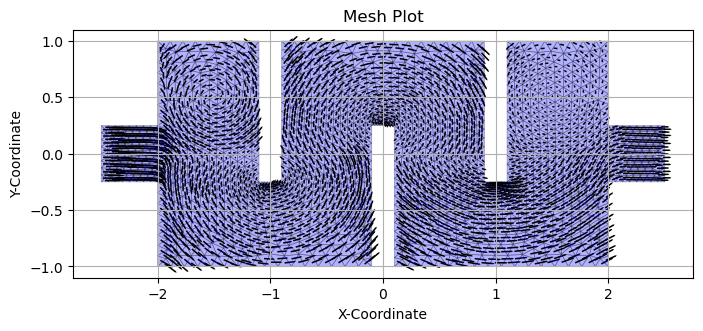

In [3]:
import src.flowField.flowField as flowField

fileName = "src/mesh/mixer.msh"
flowField.plotB(fileName)

---

##### Weak Formulation
Defining the weak formulation is straightforward.<br>
With ```ufl``` we can write symbolic code. 

In [4]:
def defineWeakForm(mu, u, v, b):
    # Diffusion Part
    FF1 = 1/mu[3] * ufl.inner(ufl.grad(u), ufl.grad(v)) * ufl.dx

    # Flow Field Part
    FF2 = ufl.inner(b, ufl.grad(u)) * v * ufl.dx

    FF = FF1 + FF2

    return FF

---

##### Boundary Conditions
Next we want to set up the boundary conditions. 

First we need to define which boundaries are part of which boundary conditions. You can either do this by defining physical vertices in Gmsh or we use ```np.logical``` functions and do it by hand. I will do it in the following by hand. 

Therefore we define functions with the following Layout: 
```
def boundary(x):
    mask = isPartOfBoundary(x)
    return mask
```
We then store these functions in a dictionary.

In [5]:
import src.boundaryCondition.defBoundaryCondition as defBc

def setUpBc():
    boundaries = [(1, defBc.outerBoundary),
                  (2, defBc.firstWall),
                  (3, defBc.secondWall),
                  (4, defBc.thirdWall),
                  (5, defBc.inlet),
                  (6, defBc.outlet)]

    return boundaries

Second we want to tag the boundaries and then save them to the mesh file.<br>
Saving to a file is optional. Doing the ```topology.create_connectivity``` command is crucial. 

In [6]:
def tagBc(mesh, boundaries):
    facet_indices, facet_markers = [], []
    
    fdim = mesh.topology.dim - 1
    
    for (marker, locator) in boundaries:
        facets = xmesh.locate_entities(mesh, fdim, locator)
        facet_indices.append(facets)
        facet_markers.append(np.full_like(facets, marker))
    
    facet_indices = np.hstack(facet_indices).astype(np.int32)
    facet_markers = np.hstack(facet_markers).astype(np.int32)
    sorted_facets = np.argsort(facet_indices)
    
    facet_tag = xmesh.meshtags(mesh, fdim, facet_indices[sorted_facets], facet_markers[sorted_facets])
    
    return facet_tag


def saveBc2Mesh(mesh, facet_tag):
    mesh.topology.create_connectivity(mesh.topology.dim-1, mesh.topology.dim)
    
    with xio.XDMFFile(mesh.comm, "./mesh/facet_tags.xdmf", "w") as xdmf:
        xdmf.write_mesh(mesh)
        xdmf.write_meshtags(facet_tag, mesh.geometry)

Next we need to apply the boundary conditions to our weak formulation. <br>
Therefore we first define a ```BoundaryCondition``` class which taggles the different kinds of boundary conditions. Then we are saving them in an array and applying it to the weak formulation. 

In [7]:
class BoundaryCondition():
    def __init__(self, type, marker, values):        
        self._type = type
        if type == "Dirichlet":
            u_D = xfem.Function(V)
            u_D.interpolate(values)
            fdim = mesh.topology.dim - 1
            facets = facet_tag.find(marker)
            dofs = xfem.locate_dofs_topological(V, fdim, facets)
            self._bc = xfem.dirichletbc(u_D, dofs)
        elif type == "Neumann":
            self._bc = ufl.inner(values, v) * ds(marker)
        else:
            raise TypeError("Unknown boundary condition: {0:s}".format(type))
    
    @property
    def bc(self):
        return self._bc

    @property
    def type(self):
        return self._type

In [8]:
# These two functions are needed to bring the parameters into the right format
# Additionally they allow an easier change of parameters 
#    and provide faster calculation

def constantBcFunction(mu):
    return lambda x: dolfinx.default_scalar_type(mu) * np.ones((x.shape[1], ))

def constantBcValues(mesh, mu):
    return xfem.Constant(mesh, dolfinx.default_scalar_type(mu))

In [9]:
def evalBc():
    boundary_conditions = [BoundaryCondition("Dirichlet", 1, constantBcFunction(0)),     # outer Boundary
                           BoundaryCondition("Dirichlet", 2, constantBcFunction(mu[0])), # first Wall
                           BoundaryCondition("Dirichlet", 3, constantBcFunction(mu[1])), # second Wall
                           BoundaryCondition("Dirichlet", 4, constantBcFunction(mu[2])), # third Wall
                           BoundaryCondition("Dirichlet", 5, constantBcFunction(0)),     # inlet
                           BoundaryCondition("Neumann"  , 6, constantBcValues(mesh, 0))] # outlet

    return boundary_conditions

In [10]:
def performBoundaryConditions(boundary_conditions, FF):
    bcs = []
    
    for condition in boundary_conditions:
        if condition.type == "Dirichlet":
            bcs.append(condition.bc)
        elif condition.type == "Neumann":
            FF -= condition.bc
        else:
            raise TypeError("Unknown boundary condition: {0:s}".format(condition.type))
            
    return FF, bcs

<font color='Red'> <b>ToDo:</b> </font> <br>
Add also "Robin" Boundary Conditions. 

---

##### Solve the problem
After we defined the weak formulation and applied the boundary conditions we can no finally solve the problem. Therefore we first determine the left hand side and the right hand side of the solution. The lhs is just the bilinearform $a(\cdot, \cdot)$, meanwhile the rhs are the other parts, like source terms, boundary conditions, ...

This can be done by 
```
# Define LHS / RHS
a = ufl.lhs(FF)
L = ufl.rhs(FF)

# Specify Solver
problem = xpetsc.LinearProblem(a, L, bcs=bcs)

# Solve the actual problem
uh = problem.solve() 
```


<font color='Red'> <b>ToDo:</b> </font> <br>
Implement a different Solver than LinearProblem. Also, try to parallelize solving the problem. 

---

##### Plotting
Before we come to the actual code we want to add a plotting function. THis one can be found in ```src.helper```. 

---

##### Solve the Problem
Finally let's put everything together and solve the problem.

An additional function we need is the integration measure, which only integrates about a specific part of the boundary. Meanwhile ```ufl.dx``` is integrating over the complete domain, we'll define a second integration measure, to only integrate about specific parts of the boundary via ```ds = ufl.Measure("ds", domain=mesh, subdomain_data=facet_tag)```.

In [11]:
### --- Imports --- ###
import numpy as np

import src.helper as helper
import dolfinx
import dolfinx.mesh as xmesh
import dolfinx.fem as xfem
import dolfinx.fem.petsc as xpetsc
import dolfinx.io as xio

import ufl


### --- Parameters --- ###
fileName = "src/mesh/mixer.msh"
mu = [1, 6, 3, 125]

### --- Actual Code --- ###
# Read in the mesh
mesh, cell_markers, facet_markers =  readMesh(fileName)

# Create FunctionSpace & Test-/Trialfunction & B-Field
V, u, v = createFunctionSpace(mesh)
b = flowField.returnB(mesh)

# Define Weak Formulation
FF = defineWeakForm(mu, u, v, b)

# Define and Perform Boundaries
boundaries = setUpBc()
facet_tag = tagBc(mesh, boundaries)
saveBc2Mesh(mesh, facet_tag)
ds = ufl.Measure("ds", domain=mesh, subdomain_data=facet_tag) 

boundary_conditions = evalBc()
FF, bcs = performBoundaryConditions(boundary_conditions, FF)

### Solve the Problem
# Define LHS / RHS
a = ufl.lhs(FF)
L = ufl.rhs(FF)

# Specify Solver
problem = xpetsc.LinearProblem(a, L, bcs=bcs)

# Solve the actual problem
uh = problem.solve()

Info    : Reading 'src/mesh/mixer.msh'...
Info    : 49 entities
Info    : 1655 nodes
Info    : 3308 elements
Info    : Done reading 'src/mesh/mixer.msh'


In [12]:
import pyvista
import trame
import ipywidgets

# Plot Solution
helper.plotSolution(uh, V)

EmbeddableWidget(value='<iframe srcdoc="<!DOCTYPE html>\n<html>\n  <head>\n    <meta http-equiv=&quot;Content-…